In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import sys
from scipy.interpolate import interp1d
from scipy import interpolate
from numba import autojit
from pylab import *
from matplotlib import gridspec
import netCDF4
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
from useful import *
from Flat_channel import *
from HB_Plot import nf, fmt
import SG as SG
import layers_calc_numba
sys.path.append('/noc/users/hb1g13/Python/python_functions/MITgcmUtils/')
import utils
%matplotlib inline

In [2]:
tau = ['3', 'Closed']
Figletter = ['a) ','b) ','c) ','d) ','e)','f)','g)','h)','j)']
# Path root
x = '/noc/msm/scratch/students/hb1g13/Mobilis/NoQ'
# Now Make file structure
check = 0
runs = []
for i in range(len(tau)):
    flist = x+'/'+str(tau[i])+'dayflat/PSI.nc'
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)
Runs=np.array(runs)

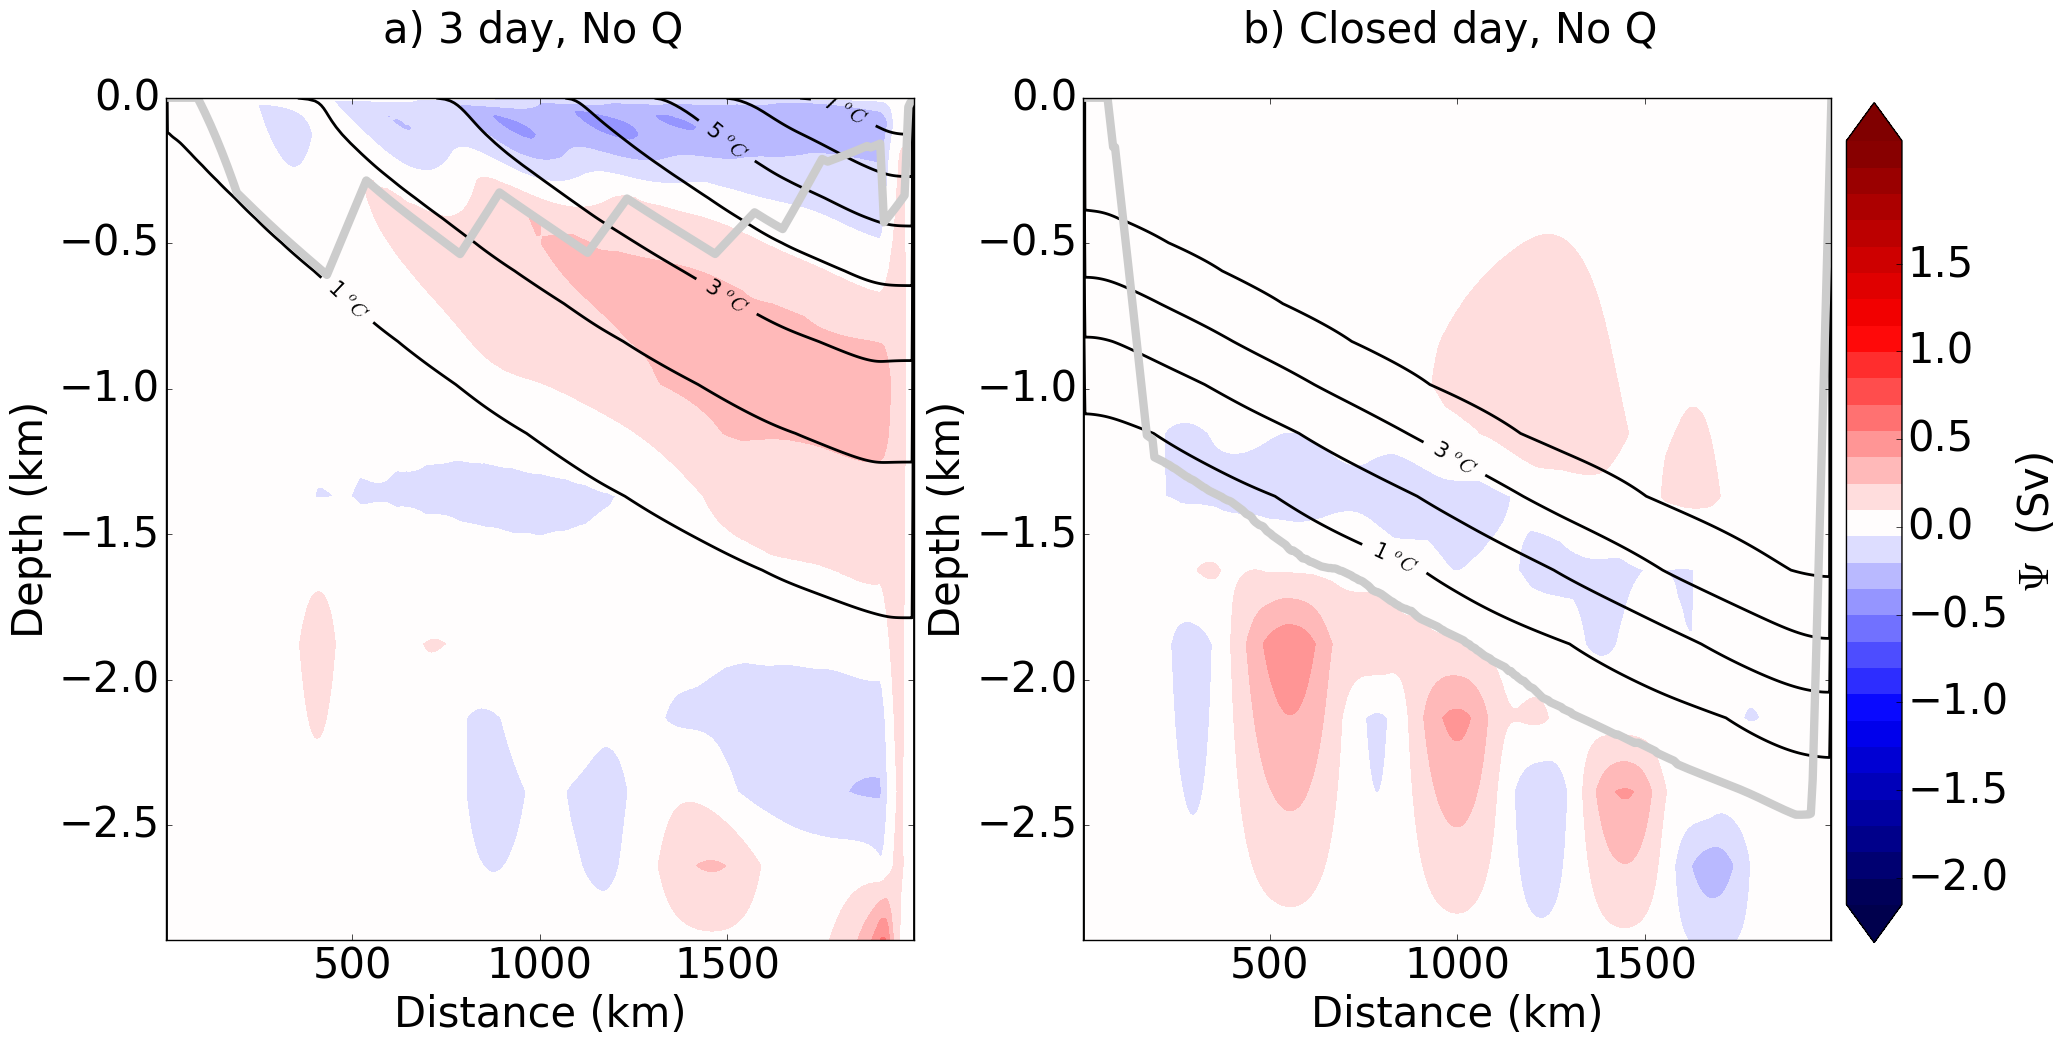

In [12]:
fig = plt.figure(figsize=(18.5, 10.5))
# Create Panels
Psi_levs = np.arange(-2.2, 2.2, .15)+0.05
Psi_ticks =np.arange(-2., 2., .5)
Eddy_ticks = (np.arange(-3, 1, .5))
E_levs = np.arange(-3., 1, .25)
Q_levs = arange(-1,8,1),arange(-1,8,1),arange(-1,8,1)
for i in range(len(Runs)):
    #i =2 
    fname = x+'/'+str(tau[Runs[i]])+'dayflat/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS

    Psi = c.get_psi_iso_z()/10**6
    g = layers_calc_numba.LayersComputer(c)
    PI = c.mnc('PSI.nc',"LaPs1TH").mean(axis=2)
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    PIz = g.transform_g_to_z(PI,th)
    PIz[-5::,50::]=np.nan
    ax = fig.add_subplot(1, 2, i+1)
    
    p = ax.contourf(c.yc/1000, c.zc/1000,
                Psi, Psi_levs, cmap=plt.cm.seismic, extend='both')
    q = ax.contour(c.yc/1000, c.zc/1000, c.get_zonal_avg('Tav.nc','THETA'), Q_levs[i], colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=15)
    #r = ax.contour(c.yg/1000,c.zc/1000, PIz,[0.999], colors='0.75', linewidths=3)
    PI = c.mnc('PSI.nc', "LaPs1TH").mean(axis=2)
    PI = ma.masked_array(PI, PI < 0.95)
    # Depths
    th = c.mnc('PSI.nc', "LaHs1TH").mean(axis=2)
    depths = np.cumsum(th[::-1], axis=0)[::-1]
    DDL = np.zeros(len(c.yc))
    psi = c.get_psi_iso()
    for jj in range(len(c.yc)):
        if (ma.all(PI[:, jj] == 1) or np.all(psi[:, jj] == -0) or PI[:, jj].mask.all()):
            continue
        indx = ma.nonzero(PI[:, jj] < 1)[0]
        b = indx
        if len(b) >= 2 and (b[1]-b[0]) > 1:
            a = b[1]
        else:
            a = b[0]
        if a < 41 and depths[a-1, jj] - depths[a, jj] > 150:
            a = a - 1
        DDL[jj] = depths[a, jj]
    r = ax.plot(c.yc/1000, SG.savitzky_golay(-DDL/1000, 21, 1), scalex=False,
                scaley=False, color='0.8', linestyle='-', linewidth=6)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+' day, No Q \n', fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Psi_ticks)
cbar.ax.set_ylabel('$\Psi$  (Sv)', fontsize=30, )
cbar.ax.tick_params(labelsize=30)